### Gene expression vs 3D changes during Legionella infection
**cmdoret**

In this report I analyse the relationship between gene expression and spatial changes in _A. castellanii_ upon _L. pneumophila_ infection. I use differential expression results from [Li et al. 2020](https://www.frontiersin.org/articles/10.3389/fcimb.2020.00428/full#h4), and have lifted over the neff v1 annotations they used to the C3 genome.
> Note: I allowed multi-mapping, which means a single C3 gene can match multiple Neff gene and vice versa.

In [1]:
import os
os.chdir('/home/cmatthey/Repos/Acastellanii_legionella_infection/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cooler

diff_expr = pd.read_csv('data/output/diff_expr/de_genes.tsv', sep='\t')
liftover = pd.read_csv('data/tmp/liftoff/neff_c3_liftover.gff', sep='\t', header=None, usecols=[0, 2, 3, 4, 8])
liftover.columns = ['chrom', 'type', 'start', 'end', 'attr']
liftover = liftover.loc[liftover['type'] == 'gene', :]
liftover['accession'] = liftover['attr'].str.replace(r'ID=gene:([^;]*);.*', r'\1')
liftover['desc'] = liftover['attr'].str.replace(r'.*description=([^;]*);.*', r'\1')

In [3]:
liftover

,chrom,type,start,end,attr,accession,desc
0,scaffold_1,gene,517,5457,ID=gene:ACA1_272090;biotype=protein_coding;des...,ACA1_272090,Ras subfamily protein
40,scaffold_1,gene,6183,9815,ID=gene:ACA1_272100;biotype=protein_coding;des...,ACA1_272100,hypothetical protein
50,scaffold_1,gene,10749,11427,ID=gene:ACA1_272220;biotype=protein_coding;des...,ACA1_272220,hypothetical protein
60,scaffold_1,gene,30871,33218,ID=gene:ACA1_272240;biotype=protein_coding;des...,ACA1_272240,hypothetical protein
82,scaffold_1,gene,33329,33978,ID=gene:ACA1_272250;biotype=protein_coding;des...,ACA1_272250,hemerythrin hhe cation binding subfamily protein
...,...,...,...,...,...,...,...
213267,scaffold_90,gene,3593,4330,ID=gene:ACA1_374170;biotype=protein_coding;des...,ACA1_374170,hypothetical protein
213275,scaffold_90,gene,9190,9784,ID=gene:ACA1_374160;biotype=protein_coding;des...,ACA1_374160,hypothetical protein
213283,scaffold_93,gene,5734,6486,ID=gene:ACA1_045660;biotype=protein_coding;des...,ACA1_045660,hypothetical protein
213289,scaffold_93,gene,6787,6829,ID=gene:ACA1_263500;biotype=protein_coding;des...,ACA1_263500,polyprotein


In [4]:
print(f"{100* diff_expr.c3.isnull().sum() / diff_expr.shape[0]:.2f}% lifted-over genes had no match in my de-novo annotation pipeline")

20.75% lifted-over genes had no match in my de-novo annotation pipeline


<IPython.core.display.Javascript object>


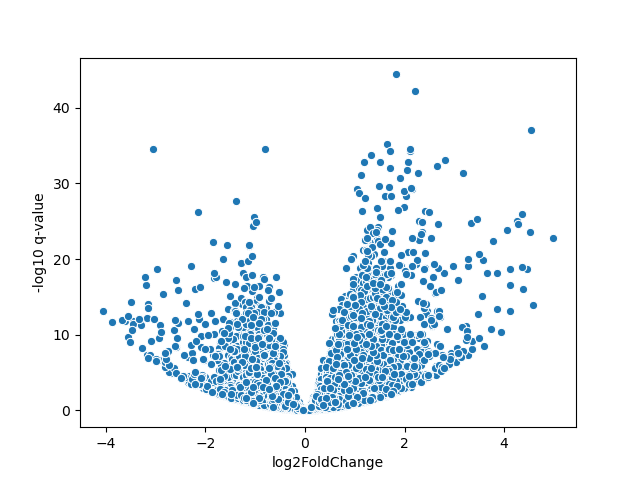

Text(0, 0.5, '-log10 q-value')

In [22]:
%matplotlib notebook

sns.scatterplot(x=diff_expr.log2FoldChange, y=-np.log10(diff_expr.padj))
plt.ylabel("-log10 q-value")

Let's subset genes which are highly differentially expressed:


In [23]:
PADJ_THRESH = 0.05
L2FC_THRESH = 2

In [24]:
sig_expr = diff_expr.loc[(diff_expr.padj < PADJ_THRESH) & (abs(diff_expr.log2FoldChange) > L2FC_THRESH), :].sort_values('padj')

In [25]:
sig_expr = sig_expr.merge(liftover, on='accession', how='left').sort_values('padj')

In [26]:
print(
    f'We subsetted {sig_expr.shape[0]} genes ({100*sig_expr.shape[0] / diff_expr.shape[0]:.2f}%) ',
    f'with more than {L2FC_THRESH} log2 fold change and adjusted p-value below {PADJ_THRESH}.')

We subsetted 316 genes (1.97%)  with more than 2 log2 fold change and adjusted p-value below 0.05.


Li et al reported that sirtuin-related genes were upregulated during infection, notably ACA1_153540. Let's have a look at these.

In [27]:
sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]


,accession,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,c3,chrom,type,start,end,attr,desc
19,ACA1_153540,1458.066017,4.365291,0.388818,11.227093,3.000000e-29,1.060000e-26,FUN_007560,scaffold_24,gene,875568.0,878213.0,ID=gene:ACA1_153540;biotype=protein_coding;des...,"transcriptional regulator, Sir2 family protein"


It is indeed in our top differentially expressed gene list. 

### Computing gene-based statistics from Hi-C data

So if we want to associate expression data to Hi-C data, we need to tie contact values to individual genes.
What I will do here is retrieve contact values between all pairs of genes before and after infection (2 replicates each). For every gene pair, I will then compute a contact change score (ratio, t-test, ...).
This will give us an interaction change network of NxN genes. I will then see how interaction change relate to co-expression using the RNAseq.

> Note: All this will be done on the normalized and detrended matrix to correct for accessibility and genomic distance.

In [36]:
hic_samples = pd.read_csv('samples.tsv', sep='\t', comment='#')
clr_ctl = cooler.Cooler('data/output/cool/uninfected_merged_subsampled.cool')
clr_inf = cooler.Cooler('data/output/cool/infected_merged_subsampled.cool')

In [71]:
clp.__version__

'0.9.5'

In [65]:
# Use the coolpup.py API to compute average contacts between all pairs of genes
import coolpuppy as clp
TMP_BED = 'tmp.bed'
bed = sig_expr.loc[:, ['chrom', 'start', 'end', 'accession']]
bed = bed.dropna(axis=0)
bed.start = bed.start.astype(int)
bed.end = bed.end.astype(int)
bed.to_csv(sep='\t', header=False, index=False)
coord_creator = clp.CoordCreator(TMP_BED, resolution = clr_ctl.info['bin-size'])
clp.PileUpper(clr_ctl,coord_creator)

AttributeError: 'CoordCreator' object has no attribute 'final_chroms'

In [83]:
"""
Next:
1. Retrieve matrix window for each pair of gene
2. Compute window average (detrended)
3. Repeat 1&2 for all 4 samples
4. Compute change estimator for each pair of gene (e.g. (c1r1+c1r2)/(c2r1+c2r2))
5. Relate gene pairs with coexpression data
    a. Correlation between coexp and contact change gene pairs
    b. diff gene consistant direction ? down expr == down contact ?
"""


SyntaxError: invalid syntax (<ipython-input-83-fef12c03be3f>, line 1)

In [84]:
coord_creator = clp.CoordCreator(TMP_BED, resolution = clr_ctl.info['bin-size'])
coord_creator.bases

AttributeError: 'CoordCreator' object has no attribute 'bases'

In [76]:
[i for i in coord_creator.chrom_mids()]
 

AttributeError: 'CoordCreator' object has no attribute 'final_chroms'

In [34]:
hic_samples

def load_cool(sample):
    """Load a cool file using corresponding sample name. Hardcoded path."""
    clr = cooler.Cooler(f'data/output/cool/{sample}.cool')
    return clr
hic_samples['cool'] = hic_samples.library.apply(load_cool)

In [35]:
hic_samples

,library,condition,infection_time,protocol,date,cool
0,AT418,infected,5,hic_arima_dpnII,2020-05,"<Cooler ""AT418.cool::/"">"
1,AT419,uninfected,0,hic_arima_dpnII,2020-05,"<Cooler ""AT419.cool::/"">"
2,AT420,infected,5,hic_arima_dpnII,2020-05,"<Cooler ""AT420.cool::/"">"
3,AT421,uninfected,0,hic_arima_dpnII,2020-05,"<Cooler ""AT421.cool::/"">"


In [29]:
def build_gene_contact_mat(clr, liftover):
    for ix, gene in liftover.iterrows():
        clr.matrix(balance=True).fetch(f"{gene['chrom']}:{gene['start']}-{gene['end']}")
    return mat

sir = sig_expr.loc[sig_expr.accession ==  'ACA1_153540', :]
sir_pos = clr_inf.extent(f'{sir.chrom.values[0]}:{int(sir.start.values[0])}-{int(sir.end.values[0])}')[0]
sir_pos -= clr_inf.extent(sir.chrom.values[0])[0]
sir_ctl = clr_ctl.matrix(balance=False).fetch(sir.chrom.values[0])
sir_inf = clr_inf.matrix(balance=False).fetch(sir.chrom.values[0])

In [30]:
import serpentine as serp
sA, sB, sk = serp.serpentin_binning(sir_inf, sir_ctl, parallel=1, triangular=True)

2020-11-18 19:47:30.491496 Starting 10 binning processes...
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106417 (66.55430126020201 %)
2	 Total serpentines: 36729 (22.970699521561023 %)
3	 Total serpentines: 13201 (8.256043028237281 %)
4	 Total serpentines: 5641 (3.5279402107633135 %)
5	 Total serpentines: 3181 (1.9894305638074987 %)
6	 Total serpentines: 2525 (1.5791613246192815 %)
7	 Total serpentines: 2358 (1.4747177835454517 %)
8	 Total serpentines: 2340 (1.4634603958847994 %)
9	 Total serpentines: 2339 (1.4628349854592075 %)
9	 Over: 2020-11-18 19:47:34.117573
0	 Total serpentines: 159895 (100.0 %)
1	 Total serpentines: 106331 (66.50051596360112 %)
2	 Total serpentines: 36764 (22.992588886456737 %)
3	 Total serpentines: 13295 (8.31483160824291 %)
4	 Total serpentines: 5634 (3.523562337784171 %)
5	 Total serpentines: 3232 (2.0213264955126804 %)
6	 Total serpentines: 2533 (1.5841646080240157 %)
7	 Total serpentines: 2379 (1.4878514024828793 %)
8	 Total serpentines: 23

In [31]:
sir_pos

437

<IPython.core.display.Javascript object>


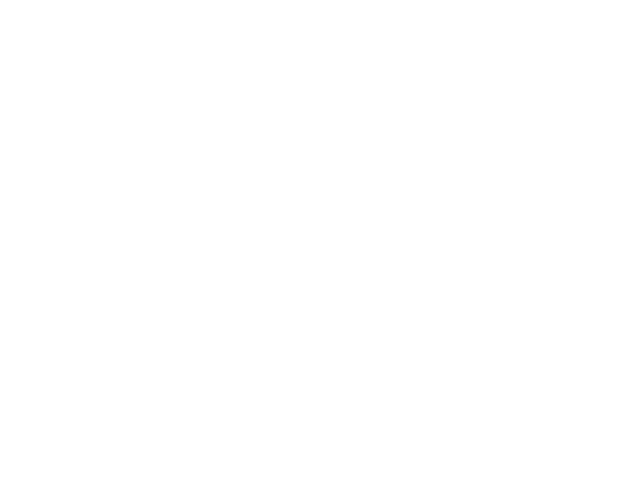

In [15]:
%matplotlib notebook
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True)
ax[0].imshow(np.log(sA), cmap='Reds')
ax[1].imshow(np.log(sB), cmap='Reds')
ax[2].imshow(sk, cmap='bwr')
for i in range(3):
    ax[i].axvline(sir_pos)
    ax[i].axhline(sir_pos)


Now, we will compare differential looping results from pareidolia with differential expression data.

In [15]:
loops_diff = pd.read_csv(
    'data/output/pareidolia/loops_small_change_infection_time.tsv',
    sep='\t',
)

In [16]:
loops_diff

,chrom1,start1,end1,chrom2,start2,end2,bin1,bin2,diff_score
0,scaffold_1,16000,18000,scaffold_1,48000,50000,8.0,24.0,0.000000
1,scaffold_1,84000,86000,scaffold_1,106000,108000,42.0,53.0,0.000000
2,scaffold_1,122000,124000,scaffold_1,134000,136000,61.0,67.0,0.000000
3,scaffold_1,142000,144000,scaffold_1,158000,160000,71.0,79.0,0.000000
4,scaffold_1,250000,252000,scaffold_1,272000,274000,125.0,136.0,0.000000
...,...,...,...,...,...,...,...,...,...
583,scaffold_33,296000,298000,scaffold_33,316000,318000,21754.0,21764.0,0.000000
584,scaffold_34,52000,54000,scaffold_34,70000,72000,21809.0,21818.0,0.219878
585,scaffold_34,214000,216000,scaffold_34,234000,236000,21890.0,21900.0,0.000000
586,scaffold_35,4000,6000,scaffold_35,20000,22000,21934.0,21942.0,0.000000


In [17]:
loop24 = loops_diff.loc[loops_diff.chrom1 == 'scaffold_24', :]
start24 = clr_inf.extent('scaffold_24')[0]
loop24.bin1 -= start24
loop24.bin2 -= start24

NameError: name 'clr_inf' is not defined

In [18]:
loop24

,chrom1,start1,end1,chrom2,start2,end2,bin1,bin2,diff_score
460,scaffold_24,232000,234000,scaffold_24,256000,258000,17316.0,17328.0,0.000000
461,scaffold_24,296000,298000,scaffold_24,310000,312000,17348.0,17355.0,0.000000
462,scaffold_24,374000,376000,scaffold_24,394000,396000,17387.0,17397.0,0.000000
463,scaffold_24,566000,568000,scaffold_24,592000,594000,17483.0,17496.0,0.000000
464,scaffold_24,632000,634000,scaffold_24,652000,654000,17516.0,17526.0,0.273440
465,scaffold_24,666000,668000,scaffold_24,694000,696000,17533.0,17547.0,0.266239
466,scaffold_24,696000,698000,scaffold_24,738000,740000,17548.0,17569.0,0.192888
467,scaffold_24,732000,734000,scaffold_24,752000,754000,17566.0,17576.0,0.000000
468,scaffold_24,1056000,1058000,scaffold_24,1074000,1076000,17728.0,17737.0,0.000000


<IPython.core.display.Javascript object>


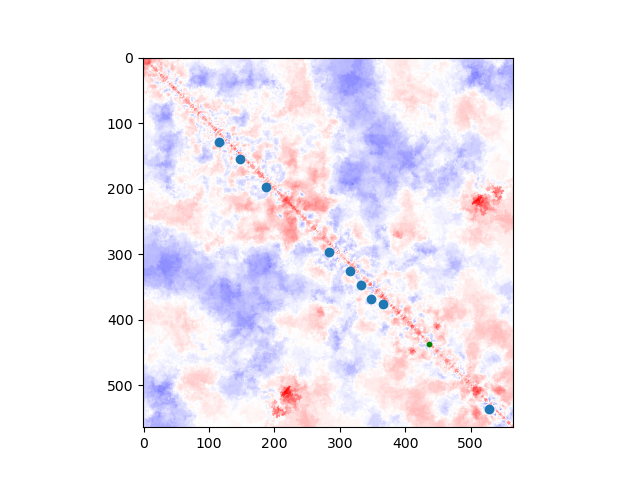

In [20]:
%matplotlib notebook
plt.imshow(sk, cmap='bwr')
plt.scatter(loop24.bin1, loop24.bin2)
s = clr_inf.extent('scaffold_24:875568-875568')[0] - start24
plt.scatter(s, s, s=10, c='green')

#### Co-variation of gene expression and 3D changes over time

I have formatted the data from Li et al to get the expression of each gene at each timepoint.
Here, I subset this dataset to include only genes that are significantly differentially expressed at the timepoint of interest. 

In [3]:
expr_time = pd.read_csv('data/output/diff_expr/expr_vs_time.tsv', sep='\t')

In [4]:
#expr_time['expr'] = 2**expr_time.log2FoldChange *   expr_time.baseMean
expr_time['expr'] = expr_time['log2FoldChange']

In [5]:
expr_mat = expr_time.loc[:, ['accession', 'time', 'expr']].pivot('accession', 'time')
expr_mat.columns = expr_mat.columns.get_level_values(1)
expr_mat.columns.name = None
expr_mat = expr_mat.dropna(axis=0)

In [6]:
corr_mat = expr_mat.transpose().corr()

In [8]:
import scipy.cluster.hierarchy as sch

def cluster_corr(corr_array, inplace=False):
    """
    Rearranges the correlation matrix, corr_array, so that groups of highly 
    correlated variables are next to eachother 
    
    Parameters
    ----------
    corr_array : pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix 
        
    Returns
    -------
    pandas.DataFrame or numpy.ndarray
        a NxN correlation matrix with the columns and rows rearranged
    """
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

<IPython.core.display.Javascript object>


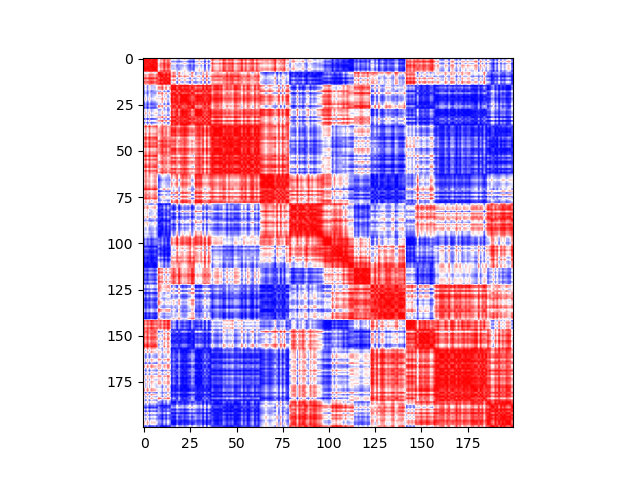

In [14]:
%matplotlib notebook


plt.imshow(cluster_corr(corr_mat.iloc[:200, :200]), cmap='bwr', vmin=-1, vmax=1)

<IPython.core.display.Javascript object>


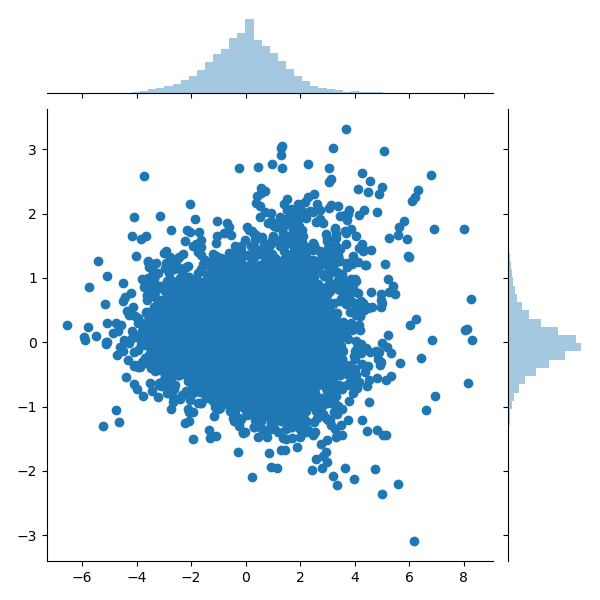

In [13]:
%matplotlib notebook
from sklearn.decomposition import PCA
import seaborn as sns
pca = PCA()
pcs = pca.fit_transform(expr_mat)
sns.jointplot(pcs[:, 0], pcs[:, 1])

<IPython.core.display.Javascript object>


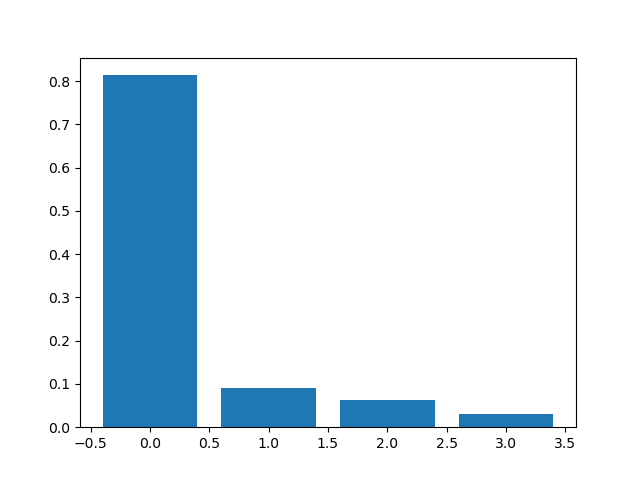

<BarContainer object of 4 artists>

In [137]:
%matplotlib notebook
plt.bar(range(pcs.shape[1]), pca.explained_variance_ratio_)

<IPython.core.display.Javascript object>


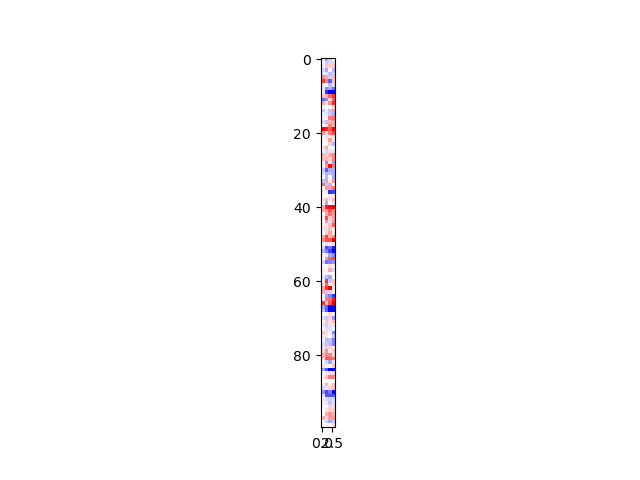

In [150]:
%matplotlib notebook
plt.imshow(expr_mat.to_numpy()[:100],cmap='bwr', vmin=-2, vmax=2)

<IPython.core.display.Javascript object>


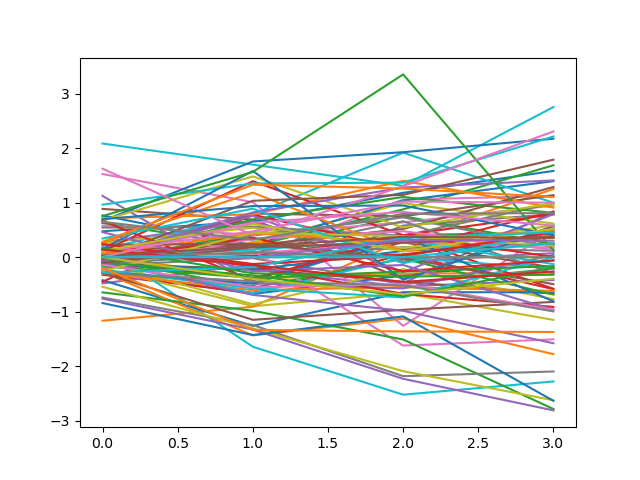

In [152]:
%matplotlib notebook
plt.plot(expr_mat.to_numpy()[:100].T)